## UTILS

In [1]:
import torch
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import rasterio
import numpy as np
from torchvision import models, transforms
import matplotlib.pyplot as plt
from torch import Tensor

class ImageDataset(Dataset):
    def __init__(self, hs_dir, RGB_dir, labels_df):
        self.RGB_dir = RGB_dir
        self.hs_dir = hs_dir
        self.labels_df = labels_df

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.index[idx]
        RGB_img_path = os.path.join(self.RGB_dir, f"{img_name}.tif")
        hs_img_path = os.path.join(self.hs_dir, f"{img_name}_hs.tif")

        with rasterio.open(RGB_img_path) as RGB_src:
            # Read the image data
            RGB_img = RGB_src.read()

        with rasterio.open(hs_img_path) as hs_src:
            # Read the image data
            hs_img = hs_src.read()

        # convert and upsample hs image
        hs_image_array = np.array(hs_img)
        hs_image_tensor = torch.from_numpy(hs_image_array)
        hs_image_tensor = hs_image_tensor.float()
        bilinear = nn.Upsample(size=200, mode='bilinear')
        hs_upsampled_tensor = bilinear(hs_image_tensor.unsqueeze(0)).squeeze(0) 

        # converting RGB to tensor
        RGB_image_array = np.array(RGB_img)
        RGB_image_tensor = torch.from_numpy(RGB_image_array)
        RGB_image_tensor = RGB_image_tensor.float()

        combined_tensor = torch.concatenate((RGB_image_tensor, hs_upsampled_tensor))

        label = self.labels_df.iloc[idx, 0]
        label = label/100

        return combined_tensor, label

#https://www.fast.ai/
#fastai code snippet
class SaveFeatures():
    features=None
    def __init__(self,m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

# https://github.com/tony-mtz/CAM/blob/master/network/utils.py
# def accuracy(input:Tensor, targs:Tensor):
#     n = targs.shape[0]
#     input = input.argmax(dim=-1).view(n,-1)
#     targs = targs.view(n,-1)
#     return (input==targs).float().mean().cpu().detach().numpy()

def accuracy(outputs:Tensor, labels:Tensor):
    conv_outputs = torch.where(outputs.squeeze() > 0.5, 1.0, 0.0)
    return (conv_outputs==labels).float().mean().detach().cpu().numpy()


#https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def imshow_transform(image_in, title=None):
    """Imshow for Tensor."""
    img = np.rollaxis(image_in.squeeze().cpu().detach().long().numpy(),0,3)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    return img

In [2]:
############
# Imports #

import torch
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import rasterio
import numpy as np
from torchvision import models, transforms
from custom_model import model_4D
from torch.autograd import Variable
from skimage.transform import resize
from skimage.io import imshow
import wandb
import matplotlib.pyplot as plt 
import torch.optim.lr_scheduler as lr_scheduler

%matplotlib inline


###################
# Hyperparameters #

n_samples = 25000
n_samples_train = int(round(n_samples*0.8))
batch_size = 40
current_computer =  "ubuntu" # "macbook" 
layers_to_freeze = 41
lr = 0.00001
weight_decay=0.04
num_epochs = 10
im_size = 100
min_palsa_positive_samples = 10


##########################
# log hyperparams to w&b #

run = wandb.init(
    # Set the project where this run will be logged
    project="VGG_CAMs",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": num_epochs,
        "batch_size": batch_size,
        "n_samples": n_samples,
        "layers_to_freeze": layers_to_freeze,
        "weight_decay": weight_decay,
        "im_size": im_size,
        "min_palsa_positive_samples": min_palsa_positive_samples
    },
    tags = ["MSELoss", "FullyConnectedClassifier", "gradCAM", "4D", "LRscheduler"]
)

#############
# Load data #

if current_computer == "ubuntu":
    hs_dir = '/home/nadjaflechner/Palsa_data/cropped_hillshade/hs'
    RGB_dir = '/home/nadjaflechner/Palsa_data/cropped_hillshade/rgb'
    labels_file = '/home/nadjaflechner/Palsa_data/cropped_hillshade/palsa_labels.csv'
elif current_computer == "macbook":
    hs_dir = '/Users/nadja/Documents/UU/Thesis/Data/cropped_hillshade/hs'
    RGB_dir = '/Users/nadja/Documents/UU/Thesis/Data/cropped_hillshade/rgb'
    labels_file = '/Users/nadja/Documents/UU/Thesis/Data/cropped_hillshade/palsa_labels.csv'

# Load the labels from the CSV file
if min_palsa_positive_samples > 0:
    labels_df = pd.read_csv(labels_file, index_col=0)
    drop_range = labels_df[ (labels_df['palsa_percentage'] > 0) & (labels_df['palsa_percentage'] <= 10) ].index
    labels_df.drop(drop_range, inplace=True)
    labels_df = labels_df.head(n_samples)
else: 
    labels_df = pd.read_csv(labels_file, index_col=0).head(n_samples)


# Split the dataset into training and validation sets
train_df = labels_df.head(n_samples_train)
val_df = labels_df.drop(train_df.index)

# Create the datasets and data loaders
train_dataset = ImageDataset(hs_dir, RGB_dir, train_df)
val_dataset = ImageDataset(hs_dir, RGB_dir, val_df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nadja-flechner (nadjaflechner). Use `wandb login --relogin` to force relogin


In [3]:
################
# Define model 

model = model_4D()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay) 
# scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.3, total_iters=10)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.92)
loss_function = nn.MSELoss()


In [5]:
##################
# Training loop #

# adapted from https://github.com/tony-mtz/CAM/blob/master/network/net.py

mean_train_losses = []
mean_val_losses = []

mean_train_acc = []
mean_val_acc = []

max_val_acc = 0

for epoch in range(num_epochs):
    print('EPOCH: ',epoch+1)

    train_acc = []
    val_acc = []

    running_loss = 0.0
    model.train()
    train_batch_count = 0

    for batch_idx, (images, labels) in enumerate(train_loader):     

        # load images and labels 
        images = Variable(images).to(device)
        labels = Variable(labels.float()).to(device)

        # train batch   
        outputs = model(images)   
        optimizer.zero_grad()
        loss = loss_function(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()  

        # calculate loss and accuracy
        # train_acc.append(accuracy(outputs.squeeze(), labels.float()))
        running_loss += loss.item()
        train_batch_count += 1
   
    model.eval()
    val_batch_count = 0
    val_running_loss = 0.0
    model.to(device)

    for batch_idx, (images, labels) in enumerate(val_loader):     
        # inference   
        images = Variable(images).to(device)
        labels = Variable(labels.float()).to(device)
        outputs = model(images)

        loss = loss_function(outputs, labels.unsqueeze(1))

        # val_acc.append(accuracy(outputs.squeeze(), labels.float()))
        val_running_loss += loss.item()
        val_batch_count +=1

    scheduler.step()

    # update losses and accuracies 

    # mean_train_acc.append(np.mean(train_acc))
    # # mean_val_acc.append(np.mean(val_acc))
    mean_train_losses.append(running_loss/train_batch_count)
    mean_val_losses.append(val_running_loss/val_batch_count)

    # # wandb.log({"train_accuracy": np.mean(train_acc)})
    # # wandb.log({"val_accuracy": np.mean(val_acc)})
    wandb.log({"train_loss": running_loss/train_batch_count})
    wandb.log({"val_loss": val_running_loss/val_batch_count})

#     if np.mean(val_acc) > max_val_acc:
#         best_model = model.state_dict()
#         max_val_acc = np.mean(val_acc)

# torch.save(best_model, '/home/nadjaflechner/models/model.pth')
# artifact = wandb.Artifact('model', type='model')
# artifact.add_file('/home/nadjaflechner/models/model.pth')
# run.log_artifact(artifact)


EPOCH:  1
EPOCH:  2
EPOCH:  3
EPOCH:  4
EPOCH:  5
EPOCH:  6
EPOCH:  7
EPOCH:  8
EPOCH:  9
EPOCH:  10


ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

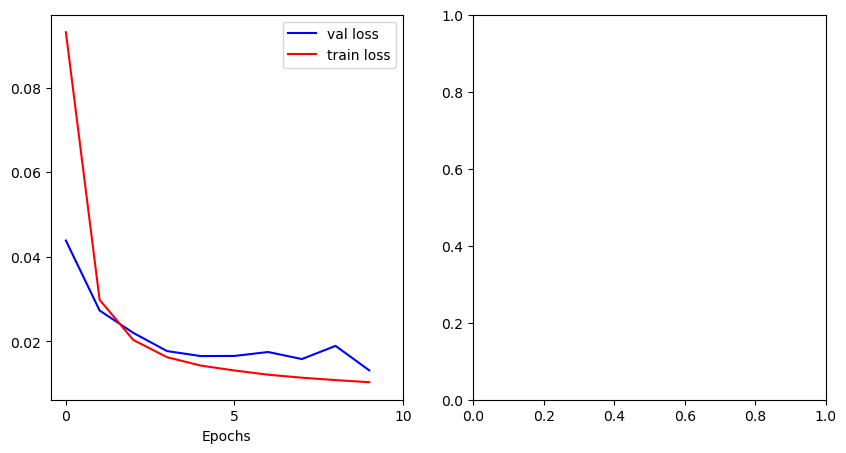

In [8]:
##########################
# plot loss and accuracy #

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))

ax1.plot([i for i in range(num_epochs)], mean_val_losses, c = 'b', label = 'val loss')
ax1.plot([i for i in range(num_epochs)], mean_train_losses, c = 'r', label = 'train loss')
ax1.set_xlabel("Epochs")
ax1.set_xticks(range(0,num_epochs+1,5))
ax1.legend()

ax2.plot([i for i in range(num_epochs)], mean_val_acc, c = 'b', label = 'val accuracy')
ax2.plot([i for i in range(num_epochs)], mean_train_acc, c = 'r', label = 'train accuracy')
ax2.set_xlabel("Epochs")
ax2.set_xticks(range(0,num_epochs+1,5))
ax2.legend()

plt.tight_layout()
plt.show()

wandb.log({'model_performance': wandb.Image(fig)})

In [9]:
# model = model_4D()
# model.load_state_dict(best_model)
model.to('cpu')
model.eval()

model_4D(
  (features): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(

In [10]:
# defines two global scope variables to store our gradients and activations

# ALL THE BELOW IS BASED OFF OF https://towardsdatascience.com/grad-cam-in-pytorch-use-of-forward-and-backward-hooks-7eba5e38d569

gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
  global gradients # refers to the variable in the global scope
  print('Backward hook running...')
  gradients = grad_output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Gradients size: {gradients[0].size()}') 
  # We need the 0 index because the tensor containing the gradients comes
  # inside a one element tuple.

def forward_hook(module, args, output):
  global activations # refers to the variable in the global scope
  print('Forward hook running...')
  activations = output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Activations size: {activations.size()}')

backward_hook = model.features[21].register_full_backward_hook(backward_hook, prepend=False)
forward_hook = model.features[21].register_forward_hook(forward_hook, prepend=False)

Forward hook running...
Activations size: torch.Size([1, 1, 25, 25])
Backward hook running...
Gradients size: torch.Size([1, 1, 25, 25])
Forward hook running...
Activations size: torch.Size([1, 1, 25, 25])
Backward hook running...
Gradients size: torch.Size([1, 1, 25, 25])
Forward hook running...
Activations size: torch.Size([1, 1, 25, 25])
Backward hook running...
Gradients size: torch.Size([1, 1, 25, 25])
Forward hook running...
Activations size: torch.Size([1, 1, 25, 25])
Backward hook running...
Gradients size: torch.Size([1, 1, 25, 25])
Forward hook running...
Activations size: torch.Size([1, 1, 25, 25])
Backward hook running...
Gradients size: torch.Size([1, 1, 25, 25])
Forward hook running...
Activations size: torch.Size([1, 1, 25, 25])
Backward hook running...
Gradients size: torch.Size([1, 1, 25, 25])
Forward hook running...
Activations size: torch.Size([1, 1, 25, 25])
Backward hook running...
Gradients size: torch.Size([1, 1, 25, 25])
Forward hook running...
Activations size:

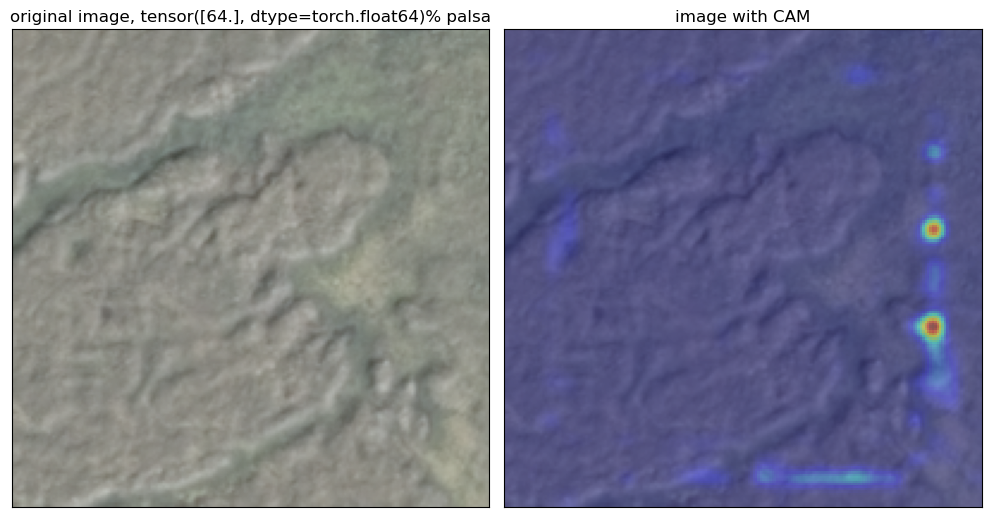

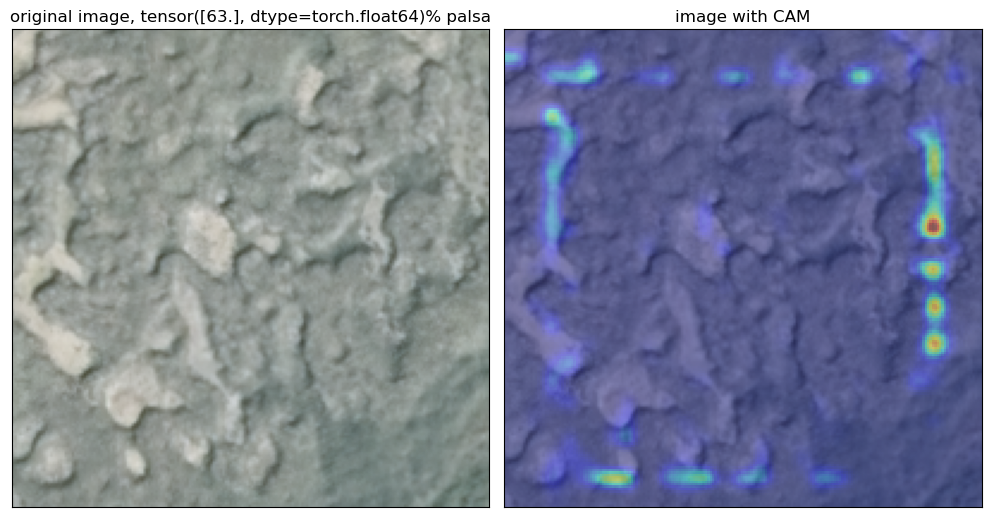

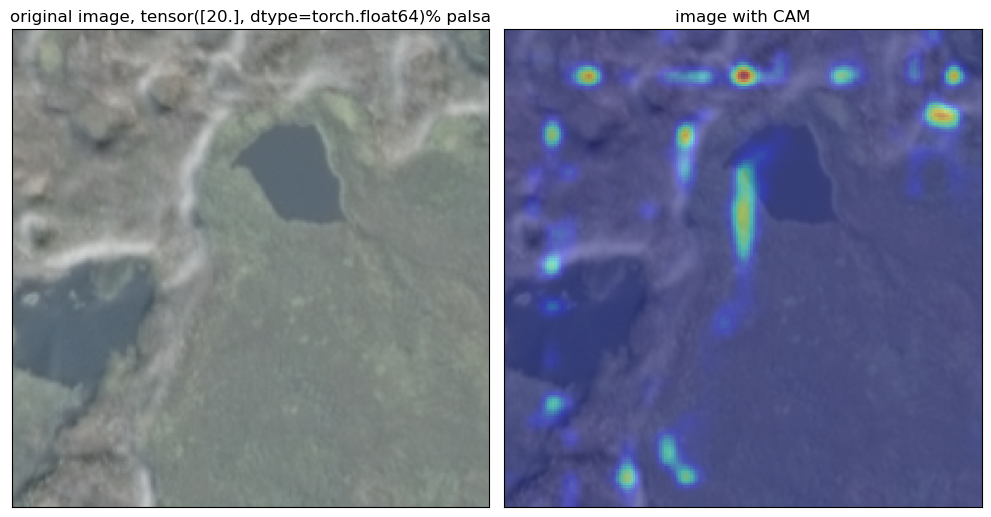

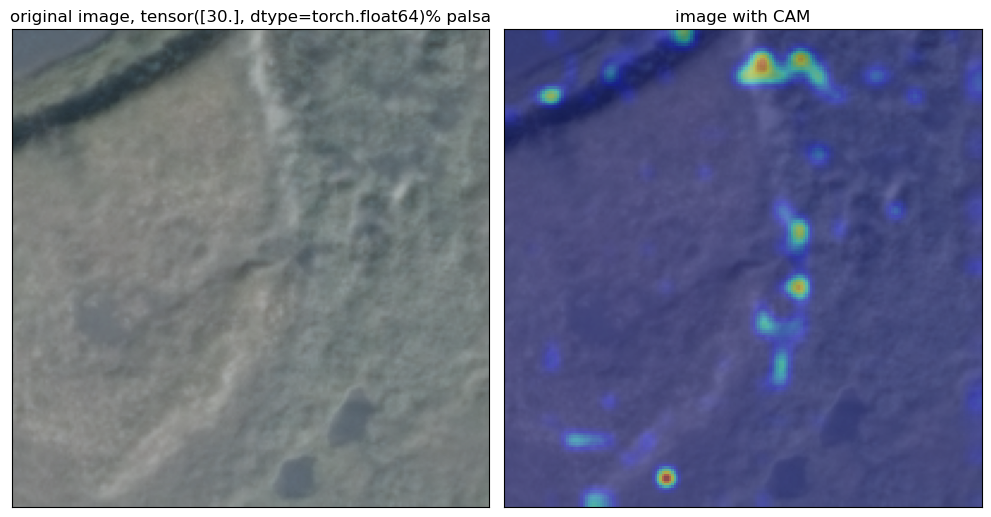

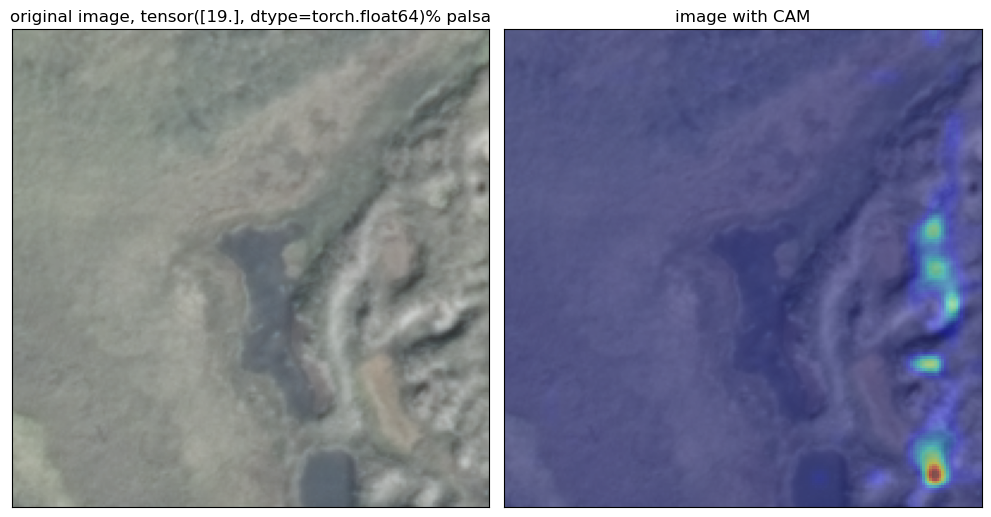

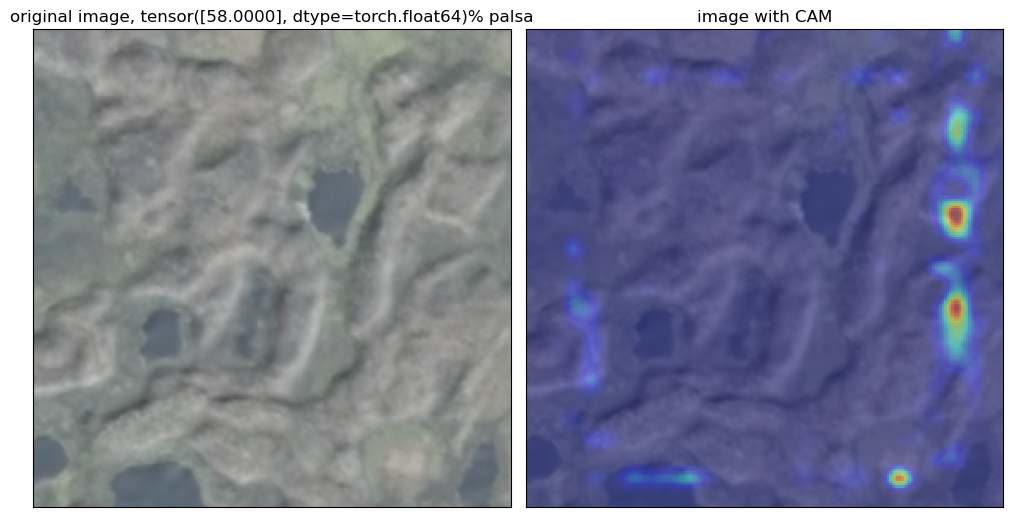

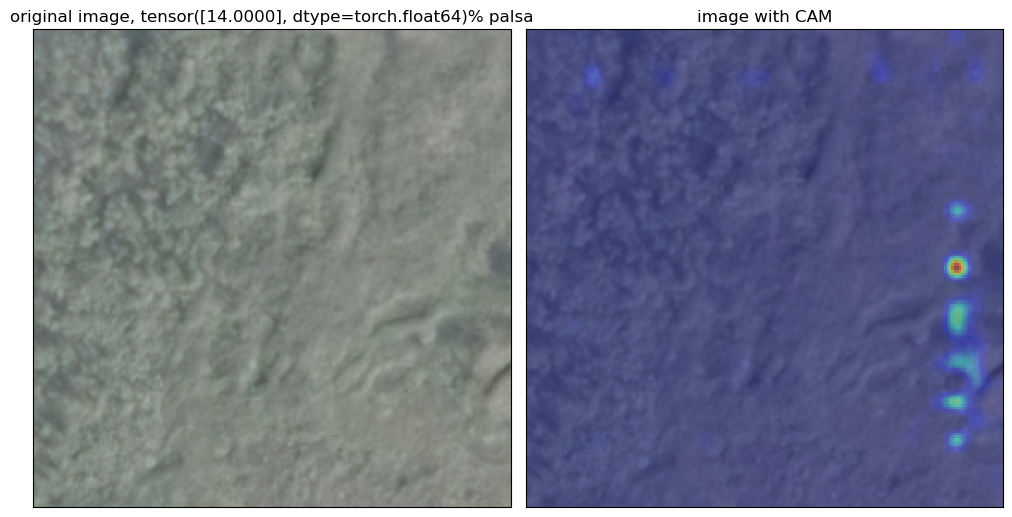

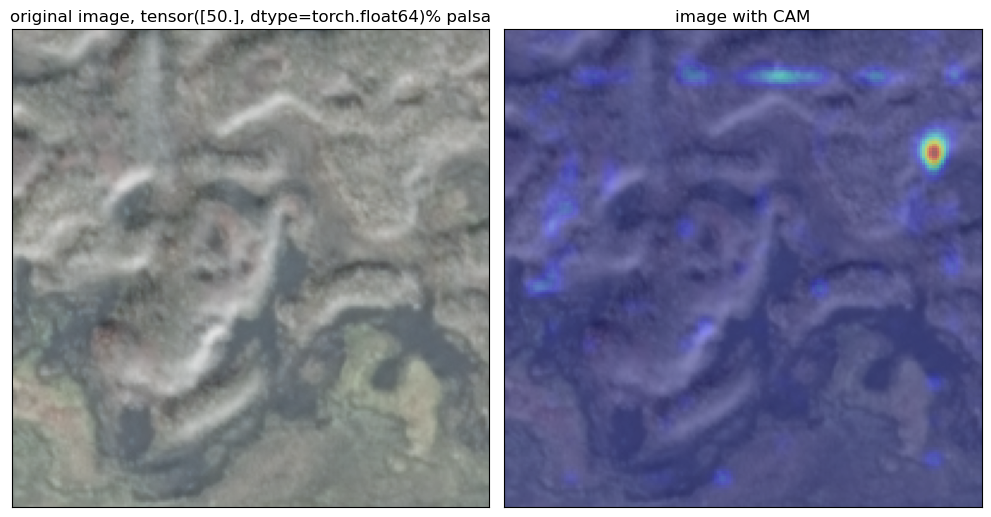

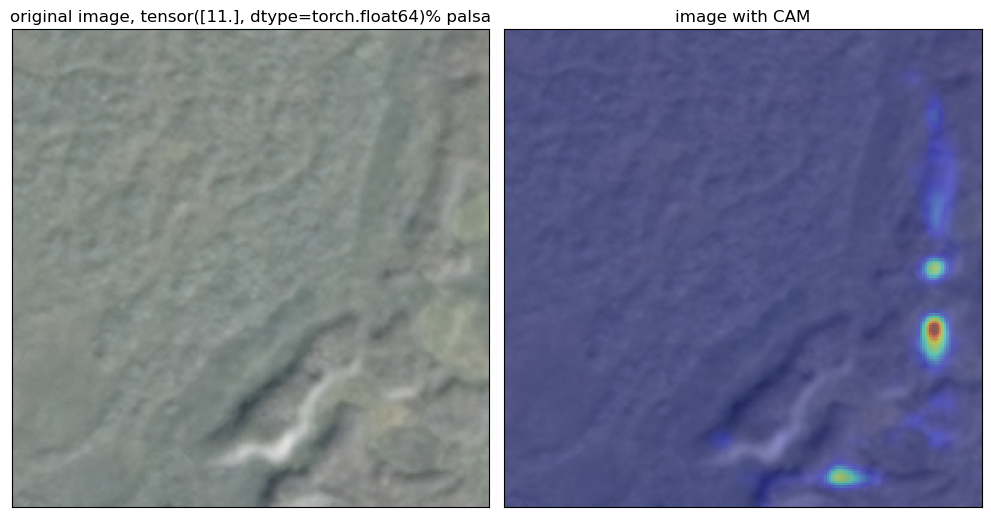

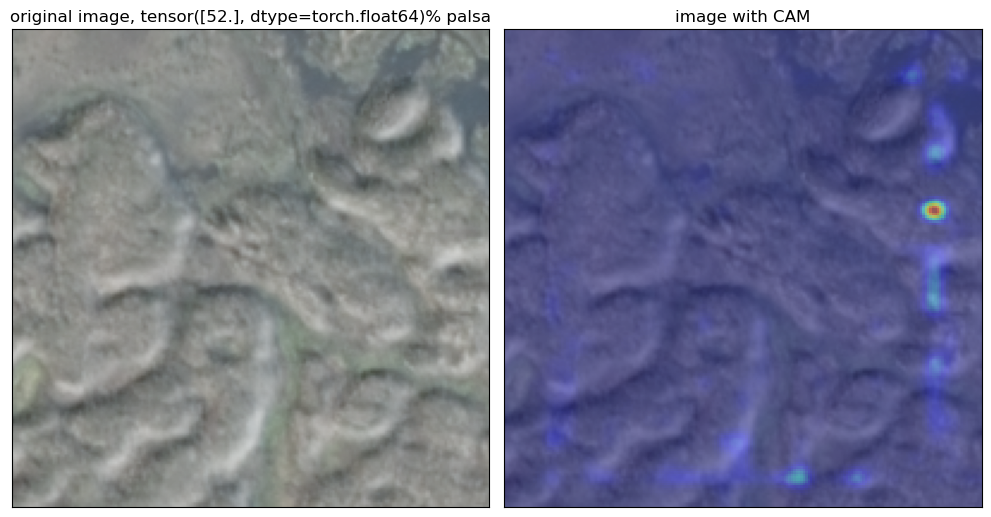

In [12]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
import numpy as np
import PIL

# model.load_state_dict(best_model)
# model.eval()

# weights = models.VGG16_BN_Weights.DEFAULT
# transforms = weights.transforms()

#change batch size to 1 to grab one image at a time
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, 
                                          shuffle=True,
                                          num_workers=1)

palsa_imgs = 0
while palsa_imgs < 10:
    im, lab = next(iter(valid_loader))
    if lab > 0.1:
        palsa_imgs += 1

        im = Variable(im)#.to(device)
        outputs = model(im)
        outputs.backward()

        pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])

        # weight the channels by corresponding gradients
        for i in range(activations.size()[1]):
            activations[:, i, :, :] *= pooled_gradients[i]

        # average, relu and normalize heatmap
        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)

        # Plot image with CAM
        cpu_img = im.squeeze().cpu().detach().permute(1,2,0).long().numpy()

        fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,7))

        ax1.imshow(cpu_img)
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.set_title(f'original image, {lab*100}% palsa')

        ax2.imshow(cpu_img)

        overlay = to_pil_image(heatmap.detach(), mode='F').resize((200,200), resample=PIL.Image.BICUBIC)

        # Apply any colormap you wan
        cmap = colormaps['jet']
        overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)

        # Plot the heatmap on the same axes, 
        # but with alpha < 1 (this defines the transparency of the heatmap)
        ax2.imshow(overlay, alpha=0.4, interpolation='nearest') #, extent=extent)

        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.set_title('image with CAM')

        plt.tight_layout()
        wandb.log({'generated_CAM': fig})

    else:
        pass


In [ ]:
wandb.finish()

### LOGGING FORGOTTEN CAMS FROM SAVED MODELS

In [ ]:
# to load model again: 

run = wandb.init(project= 'VGG_CAMs', id= 'v6ax9crk', resume = 'must')

In [ ]:

artifact = run.use_artifact('nadjaflechner/VGG_CAMs/model:v9', type='model')
artifact_dir = artifact.download()
state_dict = torch.load(f"{artifact_dir}/model.pth")
model.load_state_dict(state_dict)
